In [1]:
# 多输出模型
import keras
from keras.models import Model
from keras.layers import Input,Dense
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import TimeDistributed
from keras.utils import plot_model
from keras.layers.merge import concatenate

#原始的导入
import urllib.request
import os
import tarfile
import pandas as pd
import numpy as np
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense,Dropout,RepeatVector, Bidirectional
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Dense, TimeDistributed, LSTM, SimpleRNN, GRU, Conv1D,Conv2D
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import KFold

# 安装graphviz的路径
import os
os.environ["PATH"] += os.pathsep + 'F:/Tools/Graphviz/bin/'  # 安装graphviz的路径

import time 

import psutil

import tensorflow as tf
import keras.backend.tensorflow_backend as KTF

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

gpu_options = tf.GPUOptions(allow_growth=True)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))



Using TensorFlow backend.
F:\Programming\Anaconda\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
print(tf.__version__)

1.15.0


In [3]:
def PreprocessData1(train_df,test_df):
    df1=train_df.drop(['name'],axis = 1)
#     df1=train_df
    ndarray1 = df1.values
    Label1 = ndarray1[:,:1]
    Features1 = ndarray1[:,1:]
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaledFeatures1 = minmax_scale.fit_transform(Features1)
    
    df2=test_df.drop(['name'],axis = 1)
#     df2=test_df
    ndarray2 = df2.values
    Label2 = ndarray2[:,:1]
    Features2 = ndarray2[:,1:]
    scaledFeatures2 = minmax_scale.transform(Features2)
    
    return scaledFeatures1,Label1,scaledFeatures2,Label2

def PreprocessData2(train_df,test_df):
    df1=train_df.drop(['name'],axis = 1)
#     df1=train_df
    ndarray1 = df1.values
    Label1 = ndarray1[:,:8]
    Features1 = ndarray1[:,8:]
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaledFeatures1 = minmax_scale.fit_transform(Features1)
    
    df2=test_df.drop(['name'],axis = 1)
#     df2=test_df
    ndarray2 = df2.values
    Label2 = ndarray2[:,:8]
    Features2 = ndarray2[:,8:]
    scaledFeatures2 = minmax_scale.transform(Features2)
    
    return scaledFeatures1,Label1,scaledFeatures2,Label2

def PreprocessData3(train_df,test_df):
    df1=train_df.drop(['name'],axis = 1)
#     df1=train_df
    ndarray1 = df1.values
    Label1 = ndarray1[:,:20]
    Features1 = ndarray1[:,20:]
    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    scaledFeatures1 = minmax_scale.fit_transform(Features1)
    
    df2=test_df.drop(['name'],axis = 1)
#     df2=test_df
    ndarray2 = df2.values
    Label2 = ndarray2[:,:20]
    Features2 = ndarray2[:,20:]
    scaledFeatures2 = minmax_scale.transform(Features2)
    
    return scaledFeatures1,Label1,scaledFeatures2,Label2

In [4]:
def show_train_history(train_history,train1,train2,train3,validation1,validation2,validation3):
    plt.plot(train_history.history[train1],",b-")
    plt.plot(train_history.history[train2],",r-")
    plt.plot(train_history.history[train3],",g-")
    plt.plot(train_history.history[validation1],",b:")
    plt.plot(train_history.history[validation2],",r:")
    plt.plot(train_history.history[validation3],",g:")
    plt.title('Training History')
    plt.ylabel('Acc/Loss')
    plt.xlabel('Epoch')
    plt.legend(['train3','validation3'])
    plt.show()
    
def get_topK(label: list, prediction: list, k: int):
    label = [int(i) for i in label]
    prediction = [float(i) for i in prediction]
    hit_the_label = 0
    k_hit = 0
    # 拿到预测值和0.5的距离
    Lst = [abs(0.5 - i) for i in prediction]
    n = 4
    index_n = []
    for i in range(n):
        index_i = Lst.index(min(Lst))
        index_n.append(index_i)
        Lst[index_i] = float('inf')
    # 全部取大于0.5的，概率最大
    pred_label = [1 if i > 0.5 else 0 for i in prediction]
    group = []

    sub = subsets([i for i in range(n)])

    def rev(rev_list):
        tmp = pred_label[:]
        for i in rev_list:
            tmp[index_n[i]] = 1 - tmp[index_n[i]]
        return tmp
    for i in sub:
        group.append(rev(i))

    # 计算每种组合的出现概率，prediction代表取1的概率
    group_prob = []
    for pred in group:
        p = 1
        for i in range(len(pred)):
            if pred[i] == 1:
                p *= prediction[i]
            else:
                p *= (1 - prediction[i])
        group_prob.append(p)

    # 拿到概率最大的k个组合的索引
    Lst = list(group_prob[:])
    index_k = []
    for i in range(k):
        index_i = Lst.index(max(Lst))
        index_k.append(index_i)
        Lst[index_i] = float('-inf')

    # 判断概率最大的k个组合 是否有某个组合命中label
    for idx in range(len(index_k)):
        if hit_the_label:
            break
        pred_label = group[index_k[idx]]
        hit = True

        for i in range(len(pred_label)):
            if pred_label[i] != label[i]:
                hit = False
        if hit:
            hit_the_label = 1
            k_hit = idx + 1
        # print(pred_label, label, hit_the_label, idx, index_k)
    # print(group)
    # for i in range(len(group_prob)):
    #     print(i, group_prob[i])
    return hit_the_label, k_hit
    
def subsets(num_list):
    res = []
    path = []

    def backtrack(nums, start_index):
        res.append(path[:])  # 收集子集，要放在终止添加的上面，否则会漏掉自己
        for i in range(start_index, len(nums)):  # 当startIndex已经大于数组的长度了，就终止了，for循环本来也结束了，所以不需要终止条件
            path.append(nums[i])
            backtrack(nums, i + 1)  # 递归
            path.pop()  # 回溯
    backtrack(num_list, 0)
    return res

def trans(z):
    return [round(n) for n in z]

In [5]:
#模型评估方法

def eval1(predProb2,test_Label):
    print("……………………………………………………………………………………………")
    print("开始进行模型评估")
    
    predLabel = [0*x for x in range(len(predProb2))]
    for i in range(len(predProb2)):
        predLabel[i] =  trans(predProb2.tolist()[i])
    y_true = test_Label
    print(type(y_true))
    # print(y_true)
    y_pred = predLabel
    print(type(y_pred))
    # print(y_pred)
    
    score1 = recall_score(y_true, y_pred, average='macro')

    score2 = recall_score(y_true, y_pred, average='micro')

    score3 = recall_score(y_true, y_pred, average='weighted')

    score4 = recall_score(y_true, y_pred, average=None)

    score5 = precision_score(y_true, y_pred, average='macro')

    score6 = precision_score(y_true, y_pred, average='micro')

    score7 = precision_score(y_true, y_pred, average='weighted')

    score8 = precision_score(y_true, y_pred, average=None)

    score9 = f1_score(y_true, y_pred, average='macro')

    score10 = f1_score(y_true, y_pred, average='micro')

    score11 = f1_score(y_true, y_pred, average='weighted')

    score12 = f1_score(y_true, y_pred, average=None)

    score13 = accuracy_score(y_true, y_pred)
    
    num_defect = 0
    for i in range(len(test_Label)):
        if test_Label[i] == 1:
            num_defect += 1
    print(num_defect/len(test_Label))
    print("|||||||||||||||||||||||||||||||")
    print('缺陷率')
    print('accuracy')
    print('recall-avg')
    print('recall-0-defect')
    print('recall-1-nodefect')
    print('precision-avg')
    print('precision-0-defect')
    print('precision-1-nodefect')
    print('F1-score')
    print('F1-score-0-defect')
    print('F1-score-1-nodefect')
    print("|||||||||||||||||||||||||||||||")
    print(num_defect/len(test_Label))  
    print(score13)
    print(score1)
    print(score4[0])
    print(score4[1])
    print(score5)
    print(score8[0])
    print(score8[1])
    print(score9)
    print(score12[0])
    print(score12[1])
    print("|||||||||||||||||||||||||||||||")
    print("=====================================================================")
    

def eval2(predProb2,test_df):
    print("……………………………………………………………………………………………")
    print("……………………………………………………………………………………………")
    print("……………………………………………………………………………………………")
    print("开始进行任务2评估")
    print("###############",software,"###############")
    test_result = pd.DataFrame()
    for i in range(len(test_df)):
        test_result[i] =  predProb2[i]

    label_result = pd.DataFrame()

    for i in range(len(test_df)):
        label_result[i] =  trans(predProb2[i])

    test_data = np.array(test_df).tolist()
    sub_acc = 0
    sum_acc = 0
    
    print("Top1的sub-accuracy")
    for i in range(len(test_df)):
#         print(test_data[i][0:8])
#         print(label_result[i])
        sum_acc += accuracy_score(test_data[i][0:8],np.array(label_result[i]).tolist())
        
    sub_acc = sum_acc / len(test_df)
    print(sub_acc)
    print("##############################")
    sub_pre = 0
    sum_pre = 0
    num_pre = 0
    print("Top1的sub-precision")
    for i in range(len(test_df)):
#         print(test_data[i][0:8])
#         print(label_result[i])

        if np.sum(label_result[i]) != 0:
            sum_pre += precision_score(test_data[i][0:8],np.array(label_result[i]).tolist(),average=None)[1]
            num_pre += 1
            
    print("Task2的Precision的分子",sum_pre)
    print("Task2的Precision的分母",num_pre)
    sub_pre = sum_pre / num_pre
    print(sub_pre)
    print("##############################")
    sub_rec = 0
    sum_rec = 0
    num_rec = 0
    print("Top1的sub-recall")
    for i in range(len(test_df)):
#         print(test_data[i][0:8])
#         print(label_result[i])

        if sum(test_data[i][0:8]) != 0:
            sum_rec += recall_score(test_data[i][0:8],np.array(label_result[i]).tolist(),average=None)[1]
            num_rec += 1
    
    print("Task2的Recall的分子",sum_rec)
    print("Task2的Recall的分母",num_rec)
    sub_rec = sum_rec / num_rec
    print(sub_rec)
    print("##############################")
    
    topk = 0
    topk_num1 = []
    top1_acc = 0
    top3_acc = 0
    top5_acc = 0
    top10_acc = 0
    
    print("data length: ",len(test_df))
    print("top 1:")
    for i in range(len(test_df)):
        preresult = np.array(test_result[i]).tolist()
        # print(test_data)
        # print(test_result)
        # print(np.array(test_result[i]).tolist())
        # print("###############")
        topk += get_topK(test_data[i][0:8],preresult ,1)[0]
        topk_num1.append(get_topK(test_data[i][0:8],preresult ,1)[1])
#         print(get_topK(test_data[i][0:8],preresult ,1)[0])
    print("sum = ",topk)
    top1_acc = topk / len(test_df)
    print("rate = ",top1_acc)
#     print(topk_num1)

    topk = 0
    topk_num3 = []
    print("##############################")
    print("top 3:")
    for i in range(len(test_df)):
        preresult = np.array(test_result[i]).tolist()
        # print(test_data)
        # print(test_result)
        # print(np.array(test_result[i]).tolist())
        # print("###############")
        topk += get_topK(test_data[i][0:8],preresult ,3)[0]
        topk_num3.append(get_topK(test_data[i][0:8],preresult ,3)[1])
#         print(get_topK(test_data[i][0:8],preresult ,3)[0])
    print("sum = ",topk)
    top3_acc = topk / len(test_df)
    print("rate = ",top3_acc)
#     print(topk_num3)

    topk = 0
    topk_num5 = []
    print("##############################")
    print("top 5:")
    for i in range(len(test_df)):
        preresult = np.array(test_result[i]).tolist()
        # print(test_data)
        # print(test_result)
        # print(np.array(test_result[i]).tolist())
        # print("###############")
        topk += get_topK(test_data[i][0:8],preresult ,5)[0]
        topk_num5.append(get_topK(test_data[i][0:8],preresult ,5)[1])
#         print(get_topK(test_data[i][0:8],preresult ,5)[0])
    print("sum = ",topk)
    top5_acc = topk / len(test_df)
    print("rate = ",top5_acc)
#     print(topk_num5)

    topk = 0
    topk_num10 = []
    print("##############################")
    print("top 10:")
    for i in range(len(test_df)):
        preresult = np.array(test_result[i]).tolist()
        # print(test_data)
        # print(test_result)
        # print(np.array(test_result[i]).tolist())
        # print("###############")
        topk += get_topK(test_data[i][0:8],preresult ,10)[0]
        topk_num10.append(get_topK(test_data[i][0:8],preresult ,10)[1])
#         print(get_topK(test_data[i][0:8],preresult ,10)[0])
    print("sum = ",topk)
    top10_acc = topk / len(test_df)
    print("rate = ",top10_acc)
#     print(topk_num10)
    print("##############################")
    sum_rank = 0
    num_rank = 0
    MRR = 0
    for i in range(len(topk_num10)):
        if topk_num10[i] != 0:
            sum_rank += topk_num10[i]
            num_rank += 1
    print("top10范围下的平均排名MRR：")
    MRR = sum_rank / num_rank
    print(MRR)
    print("##############################")
    print("各类别缺陷分布统计:")
    d_num = [0,0,0,0,0,0,0,0]
    for i in range(len(test_df)):
        for j in range(8):
            if test_data[i][j] == 1:
                d_num[j] += 1 
    print(d_num)
    print("##############################")
    print("各类别缺陷预测正确率统计:")
    p_num = [0,0,0,0,0,0,0,0]
    for i in range(len(test_df)):
        preLabel = np.array(label_result[i]).tolist()    
        for j in range(8):
            if ((test_data[i][j] == 1) and (int(preLabel[j]) == 1)):
                p_num[j] += 1
    print(p_num)    
    print("|||||||||||||||||||||||||||||||")
    print(sub_acc)
    print(sub_pre)
    print(sub_rec)
    print(top1_acc)
    print(top3_acc)
    print(top5_acc)
    print(top10_acc)
    
    for k in range(8):
        print(d_num[k]/len(test_df))
    for p in range(8):
        if (d_num[p] != 0):
            print(p_num[p]/d_num[p])
        else:
            print('0')
    print(MRR)
    print("=====================================================================")
    
def eval3(predProb2,test_df):    
    print("……………………………………………………………………………………………")
    print("……………………………………………………………………………………………")
    print("……………………………………………………………………………………………")
    print("开始进行任务3评估")
    print("###############",software,"###############")
    test_result = pd.DataFrame()
    for i in range(len(test_df)):
        test_result[i] =  predProb2[i]

    label_result = pd.DataFrame()

    for i in range(len(test_df)):
        label_result[i] =  trans(predProb2[i])
   
    test_data = np.array(test_df).tolist()
    sub_acc = 0
    sum_acc = 0
    
    print("Top1的sub-accuracy")
    for i in range(len(test_df)):
#         print(test_data[i][0:8])
#         print(label_result[i])
        sum_acc += accuracy_score(test_data[i][0:20],np.array(label_result[i]).tolist())
        
    sub_acc = sum_acc / len(test_df)
    print(sub_acc)
    print("##############################")
    sub_pre = 0
    sum_pre = 0
    num_pre = 0
    print("Top1的sub-precision")
    for i in range(len(test_df)):
#         print(test_data[i][0:8])
#         print(label_result[i])
        if np.sum(label_result[i]) != 0:
            sum_pre += precision_score(test_data[i][0:20],np.array(label_result[i]).tolist(),average=None)[1]
            num_pre += 1
            
    print("Task3的Precision的分子",sum_pre)
    print("Task3的Precision的分母",num_pre)
    if num_pre != 0:
        sub_pre = sum_pre / num_pre
    else:
        sub_pre = 0
    print(sub_pre)
    print("##############################")
    sub_rec = 0
    sum_rec = 0
    num_rec = 0
    print("Top1的sub-recall")
    for i in range(len(test_df)):
#         print(test_data[i][0:8])
#         print(label_result[i])        
        if sum(test_data[i][0:20]) != 0:
            sum_rec += recall_score(test_data[i][0:20],np.array(label_result[i]).tolist(),average=None)[1]
            num_rec += 1
            
    print("Task3的Recall的分子",sum_rec)
    print("Task3的Recall的分母",num_rec)
    sub_rec = sum_rec / num_rec
    print(sub_rec)
    print("##############################")
    
    topk = 0
    topk_num1 = []
    top1_acc = 0
    top3_acc = 0
    top5_acc = 0
    top10_acc = 0
    
    print("data length: ",len(test_df))
    print("top 1:")
    for i in range(len(test_df)):
        preresult = np.array(test_result[i]).tolist()
        # print(test_data)
        # print(test_result)
        # print(np.array(test_result[i]).tolist())
        # print("###############")
        topk += get_topK(test_data[i][0:20],preresult ,1)[0]
        topk_num1.append(get_topK(test_data[i][0:20],preresult ,1)[1])
#         print(get_topK(test_data[i][0:8],preresult ,1)[0])
    print("sum = ",topk)
    top1_acc = topk / len(test_df)
    print("rate = ",top1_acc)
#     print(topk_num1)

    topk = 0
    topk_num3 = []
    print("##############################")
    print("top 3:")
    for i in range(len(test_df)):
        preresult = np.array(test_result[i]).tolist()
        # print(test_data)
        # print(test_result)
        # print(np.array(test_result[i]).tolist())
        # print("###############")
        topk += get_topK(test_data[i][0:20],preresult ,3)[0]
        topk_num3.append(get_topK(test_data[i][0:20],preresult ,3)[1])
#         print(get_topK(test_data[i][0:8],preresult ,3)[0])
    print("sum = ",topk)
    top3_acc = topk / len(test_df)
    print("rate = ",top3_acc)
#     print(topk_num3)

    topk = 0
    topk_num5 = []
    print("##############################")
    print("top 5:")
    for i in range(len(test_df)):
        preresult = np.array(test_result[i]).tolist()
        # print(test_data)
        # print(test_result)
        # print(np.array(test_result[i]).tolist())
        # print("###############")
        topk += get_topK(test_data[i][0:20],preresult ,5)[0]
        topk_num5.append(get_topK(test_data[i][0:20],preresult ,5)[1])
#         print(get_topK(test_data[i][0:8],preresult ,5)[0])
    print("sum = ",topk)
    top5_acc = topk / len(test_df)
    print("rate = ",top5_acc)
#     print(topk_num5)

    topk = 0
    topk_num10 = []
    print("##############################")
    print("top 10:")
    for i in range(len(test_df)):
        preresult = np.array(test_result[i]).tolist()
        # print(test_data)
        # print(test_result)
        # print(np.array(test_result[i]).tolist())
        # print("###############")
        topk += get_topK(test_data[i][0:20],preresult ,10)[0]
        topk_num10.append(get_topK(test_data[i][0:20],preresult ,10)[1])
#         print(get_topK(test_data[i][0:8],preresult ,10)[0])
    print("sum = ",topk)
    top10_acc = topk / len(test_df)
    print("rate = ",top10_acc)
#     print(topk_num10)
    print("##############################")
    sum_rank = 0
    num_rank = 0
    MRR = 0
    for i in range(len(topk_num10)):
        if topk_num10[i] != 0:
            sum_rank += topk_num10[i]
            num_rank += 1
    print("top10范围下的平均排名MRR：")
    MRR = sum_rank / num_rank
    print(MRR)
    print("##############################")
    print("各类别缺陷分布统计:")
    d_num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(test_df)):
        for j in range(20):
            if test_data[i][j] == 1:
                d_num[j] += 1 
    print(d_num)
    print("##############################")
    print("各类别缺陷预测正确率统计:")
    p_num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for i in range(len(test_df)):
        preLabel = np.array(label_result[i]).tolist()    
        for j in range(20):
            if ((test_data[i][j] == 1) and (int(preLabel[j]) == 1)):
                p_num[j] += 1
    print(p_num)    
    print("|||||||||||||||||||||||||||||||")
    print(sub_acc)
    print(sub_pre)
    print(sub_rec)
    print(top1_acc)
    print(top3_acc)
    print(top5_acc)
    print(top10_acc)
    
    for k in range(20):
        print(d_num[k]/len(test_df))
    for p in range(20):
        if (d_num[p] != 0):
            print(p_num[p]/d_num[p])
        else:
            print('0')
    print(MRR)
    print("=====================================================================")

In [6]:
format_of_feature = ["name","lines", "true_lines",
                     "Statements", "Percent Branch Statements", "Percent Lines with Comments", "Functions",
                     "Line Number of Most Complex Function", "Line Number of Deepest Block",
                     "Maximum Block Depth", "Average Block Depth", "Average Complexity"]
ori_len_feature = len(format_of_feature)
N_location = 20
# for tool in ["cpp", 'ts', 'fl']:
#     for i in range(N_location):
#         for rank in ["err", 'warn']:
#             format_of_feature.append("_".join([tool, rank, str(i)]))

# format_of_feature += ["cpp_7pkd_0","cpp_7pkd_1","cpp_7pkd_2","cpp_7pkd_3","cpp_7pkd_4","cpp_7pkd_5","cpp_7pkd_6","cpp_7pkd_7","ts_7pkd_0","ts_7pkd_1","ts_7pkd_2","ts_7pkd_3","ts_7pkd_4","ts_7pkd_5","ts_7pkd_6","ts_7pkd_7","fl_7pkd_0","fl_7pkd_1","fl_7pkd_2","fl_7pkd_3","fl_7pkd_4","fl_7pkd_5","fl_7pkd_6","fl_7pkd_7","cpp_7pkn_0","cpp_7pkn_1","cpp_7pkn_2","cpp_7pkn_3","cpp_7pkn_4","cpp_7pkn_5","cpp_7pkn_6","cpp_7pkn_7","ts_7pkn_0","ts_7pkn_1","ts_7pkn_2","ts_7pkn_3","ts_7pkn_4","ts_7pkn_5","ts_7pkn_6","ts_7pkn_7","fl_7pkn_0","fl_7pkn_1","fl_7pkn_2","fl_7pkn_3","fl_7pkn_4","fl_7pkn_5","fl_7pkn_6","fl_7pkn_7"]            
            
format_of_jts = ["file_path", "total_lines", "true_lines", "if_bug", "bug_0_lines", "bug_1_lines",
                 "7pk_0", "7pk_1", "7pk_2", "7pk_3", "7pk_4", "7pk_5", "7pk_6", "7pk_7"]
ori_len_jts = len(format_of_jts)
for i in range(N_location):
    format_of_jts.append("bug"+str(i))
s1 = ""
s2 = ""
for i in range(len(format_of_feature)):
    s1 += str(i) + ":" + format_of_feature[i]+ "   "
print(s1)
print()
for i in range(len(format_of_jts)):
    s2 += str(i) + ":" + format_of_jts[i]+ "   "
print(s2)


0:name   1:lines   2:true_lines   3:Statements   4:Percent Branch Statements   5:Percent Lines with Comments   6:Functions   7:Line Number of Most Complex Function   8:Line Number of Deepest Block   9:Maximum Block Depth   10:Average Block Depth   11:Average Complexity   

0:file_path   1:total_lines   2:true_lines   3:if_bug   4:bug_0_lines   5:bug_1_lines   6:7pk_0   7:7pk_1   8:7pk_2   9:7pk_3   10:7pk_4   11:7pk_5   12:7pk_6   13:7pk_7   14:bug0   15:bug1   16:bug2   17:bug3   18:bug4   19:bug5   20:bug6   21:bug7   22:bug8   23:bug9   24:bug10   25:bug11   26:bug12   27:bug13   28:bug14   29:bug15   30:bug16   31:bug17   32:bug18   33:bug19   


In [7]:
#导入数据文件
software = 'jts_java'
method = ''
# method = 'C_step2/'
# method = 'JAVA_step2/'
# 设置输出数据的格式
pd.set_option('precision', 5) #设置精度

cols1 = [format_of_jts[3]] + format_of_feature
print(cols1)
print("……………………………………………………………………………………………")
cols2 = format_of_jts[6:14] + format_of_feature
print(cols2)
print("……………………………………………………………………………………………")
cols3 = format_of_jts[14:34] + format_of_feature
print(cols3)

['if_bug', 'name', 'lines', 'true_lines', 'Statements', 'Percent Branch Statements', 'Percent Lines with Comments', 'Functions', 'Line Number of Most Complex Function', 'Line Number of Deepest Block', 'Maximum Block Depth', 'Average Block Depth', 'Average Complexity']
……………………………………………………………………………………………
['7pk_0', '7pk_1', '7pk_2', '7pk_3', '7pk_4', '7pk_5', '7pk_6', '7pk_7', 'name', 'lines', 'true_lines', 'Statements', 'Percent Branch Statements', 'Percent Lines with Comments', 'Functions', 'Line Number of Most Complex Function', 'Line Number of Deepest Block', 'Maximum Block Depth', 'Average Block Depth', 'Average Complexity']
……………………………………………………………………………………………
['bug0', 'bug1', 'bug2', 'bug3', 'bug4', 'bug5', 'bug6', 'bug7', 'bug8', 'bug9', 'bug10', 'bug11', 'bug12', 'bug13', 'bug14', 'bug15', 'bug16', 'bug17', 'bug18', 'bug19', 'name', 'lines', 'true_lines', 'Statements', 'Percent Branch Statements', 'Percent Lines with Comments', 'Functions', 'Line Number of Most Complex Function',

In [8]:
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dropout
from keras.layers.recurrent import LSTM
from keras.layers import TimeDistributed,RepeatVector
import math
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, LSTM, merge,Bidirectional,Multiply
from keras.models import Model

from attention_utils import get_activations
from keras.layers import merge
from keras.layers.core import *
from keras.models import *

## spatial
SINGLE_ATTENTION_VECTOR = False
def attention_s_block(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction1')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2),name='attention_vec1')(a)

    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_s_block2(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction2')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2),name='attention_vec2')(a)

    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def attention_s_block3(inputs):
    # inputs.shape = (batch_size, time_steps, input_dim)
    input_dim = int(inputs.shape[2])
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: K.mean(x, axis=1), name='dim_reduction3')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2),name='attention_vec3')(a)

    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

def get_activations(model, inputs, print_shape_only=False, layer_name=None):
    # Documentation is available online on Github at the address below.
    # From: https://github.com/philipperemy/keras-visualize-activations
    print('----- activations -----')
    activations = []
    inp = model.input
    if layer_name is None:
        outputs = [layer.output for layer in model.layers]
    else:
        outputs = [layer.output for layer in model.layers if layer.name == layer_name]  # all layer outputs
    funcs = [K.function([inp] + [K.learning_phase()], [out]) for out in outputs]  # evaluation functions
    layer_outputs = [func([inputs, 1.])[0] for func in funcs]
    for layer_activations in layer_outputs:
        activations.append(layer_activations)
        if print_shape_only:
            print(layer_activations.shape)
        else:
            print(layer_activations)
    return activations

In [9]:
start = time.clock()
info = psutil.virtual_memory()

mem1 = psutil.Process(os.getpid()).memory_info().rss

k = 0
for k in range(1):
    print("=====================================================================")
    k = k + 5
    #文件导入部分
    trainpath = 'kfold/'+ method + software + '_' + str(k) + '_20_step1_train.csv' 
    testpath = 'kfold/'+ method + software + '_' + str(k) + '_20_step1_test.csv'
    print("此为第",k,"组交叉验证数据")
    print("……………………………………………………………………………………………")
    print("训练集为:",trainpath)
    print("测试集为:",testpath)
    print("设定训练集和测试集数据")
    
    ###############数据处理部分

    train_df1 = pd.read_csv(trainpath)
    train_df1 = train_df1[cols1]
    test_df1 = pd.read_csv(testpath)
    test_df1= test_df1[cols1]
    
    train_df2 = pd.read_csv(trainpath)
    train_df2 = train_df2[cols2]
    test_df2 = pd.read_csv(testpath)
    test_df2= test_df2[cols2]
    
    train_df3 = pd.read_csv(trainpath)
    train_df3 = train_df3[cols3]
    test_df3 = pd.read_csv(testpath)
    test_df3= test_df3[cols3]
    print("……………………………………………………………………………………………")
    print(len(train_df1),len(test_df1))
    print(len(train_df2),len(test_df2))
    print(len(train_df3),len(test_df3))
    print("……………………………………………………………………………………………")
    
    train_Features1,train_Label1,test_Features1,test_Label1 = PreprocessData1(train_df1,test_df1)
    train_Features2,train_Label2,test_Features2,test_Label2 = PreprocessData2(train_df2,test_df2)
    train_Features3,train_Label3,test_Features3,test_Label3 = PreprocessData3(train_df3,test_df3)
    
    # RNN需使用以下代码
    train_Features = train_Features1
    test_Features = test_Features1
    train_Label = train_Label1
    test_Label = test_Label1 
    
    train_Features1 = train_Features1.reshape(train_Features1.shape[0], 1, train_Features1.shape[1])
    test_Features1 = test_Features1.reshape(test_Features1.shape[0], 1, test_Features1.shape[1])
    train_Features2 = train_Features2.reshape(train_Features2.shape[0], 1, train_Features2.shape[1])
    test_Features2 = test_Features2.reshape(test_Features2.shape[0], 1, test_Features2.shape[1])
    train_Features3 = train_Features3.reshape(train_Features3.shape[0], 1, train_Features3.shape[1])
    test_Features3 = test_Features3.reshape(test_Features3.shape[0], 1, test_Features3.shape[1])
    
    train_Label1.astype(np.float64)
    test_Label1.astype(np.float64)
    train_Label2.astype(np.float64)
    test_Label2.astype(np.float64)
    train_Label3.astype(np.float64)
    test_Label3.astype(np.float64)
    
    ###############网络部分
    #  179 = 11 + 20*2*3 + 8*2*3 
    Features = 179
    
    #公共输入层
    inputs = Input(shape=(1, Features),name='inputs')     
    
    #公共编码层   
    #编码
#     encode1 = Conv1D(filters = 256, kernel_size = 3, input_shape = (1, 179),padding = 'same', activation = 'relu',name='encode1')(attention)
#     encode2 = GRU(64,activation='relu',name='encode2')(encode1)
#     encode3 = Dropout(0.1,name='encode3')(encode2)
#     encode4 = RepeatVector(10,name='encode4')(encode3)
#     encode5 = Dense(32,name='encode5')(encode4)
#     encode6 = Dropout(0.1,name='encode6')(encode5)

#     #3个解码过程
#     #解码1
#     decode11 = GRU(64,activation='relu',name='decode11')(encode6)
#     decode12 = Dense(32,name='decode12')(decode11)
#     #解码2
#     decode21 = GRU(64,activation='relu',name='decode21')(encode6)
#     decode22 = Dense(32,name='decode22')(decode21)
#     #解码3
#     decode31 = GRU(64,activation='relu',name='decode31')(encode6)
#     decode32 = Dense(32,name='decode32')(decode31)
    
    #3个编码层
    #编码1
    encode11 = Conv1D(filters = 256, kernel_size = 3, input_shape = (1, Features),padding = 'same', activation = 'relu',name='encode11')(inputs)
    encode12 = GRU(64,activation='relu',name='encode12')(encode11)
    encode13 = Dropout(0.1,name='encode13')(encode12)
    encode14 = RepeatVector(1,name='encode14')(encode13)
    encode15 = Dense(32,name='encode15')(encode14)
    encode16 = Dropout(0.1,name='encode16')(encode15)

    #编码2
    encode21 = Conv1D(filters = 256, kernel_size = 3, input_shape = (1, Features),padding = 'same', activation = 'relu',name='encode21')(inputs)
    encode22 = GRU(64,activation='relu',name='encode22')(encode21)
    encode23 = Dropout(0.1,name='encode23')(encode22)
    encode24 = RepeatVector(1,name='encode24')(encode23)
    encode25 = Dense(32,name='encode25')(encode24)
    encode26 = Dropout(0.1,name='encode26')(encode25)
    
    #编码1
    encode31 = Conv1D(filters = 256, kernel_size = 3, input_shape = (1, Features),padding = 'same', activation = 'relu',name='encode31')(inputs)
    encode32 = GRU(64,activation='relu',name='encode32')(encode31)
    encode33 = Dropout(0.1,name='encode33')(encode32)
    encode34 = RepeatVector(1,name='encode34')(encode33)
    encode35 = Dense(32,name='encode35')(encode34)
    encode36 = Dropout(0.1,name='encode36')(encode35)
    
    #公共编码
    encode1 = Dense(32,name='encode1')(encode16)
    encode2 = Dense(32,name='encode2')(encode26)
    encode3 = Dense(32,name='encode3')(encode36)
    
    encodesum = keras.layers.concatenate([encode1,encode2,encode3])
    
    #Attention层
    attention = attention_s_block(encodesum)
    attention1 = Dense(96,name='attention1')(attention)
    #3个解码过程
    #解码1
    decode11 = GRU(64,activation='relu',name='decode11')(attention1)
    decode12 = Dense(32,name='decode12')(decode11)
    #解码2
    decode21 = GRU(64,activation='relu',name='decode21')(attention1)
    decode22 = Dense(32,name='decode22')(decode21)
    #解码3
    decode31 = GRU(64,activation='relu',name='decode31')(attention1)
    decode32 = Dense(32,name='decode32')(decode31)
    
    #3个输出
    output1 = Dense(units=1, kernel_initializer='uniform', activation='sigmoid',name='output1')(decode12)
    output2 = Dense(units=8, kernel_initializer='uniform', activation='sigmoid',name='output2')(decode22)
    output3 = Dense(units=20, kernel_initializer='uniform', activation='sigmoid',name='output3')(decode32)
    
    #组合网络
    model = Model(inputs=inputs,outputs=[output1, output2, output3])
    # 打印网络结构
    model.summary()
    
    #模型编译
    model.compile(optimizer='adam',loss={'output1': 'binary_crossentropy','output2': 'binary_crossentropy','output3': 'binary_crossentropy'},loss_weights={'output1':1,'output2':1,'output3':1},metrics=["accuracy"])
    
#     train_history = model.fit(train_Features, train_Label, validation_split = 0.1,epochs=200, batch_size=60, verbose=0)
     #模型训练
    train_history = model.fit(train_Features1,{'output1': train_Label1,'output2': train_Label2,'output3': train_Label3},epochs=100, batch_size=60, validation_split=0.1, verbose=1)
    


elapsed = (time.clock() - start)
print("Time used:",elapsed," s")

mem2 = psutil.Process(os.getpid()).memory_info().rss

print ('内存使用：',(mem2-mem1)/1024/1024,'MB')

此为第 5 组交叉验证数据
……………………………………………………………………………………………
训练集为: kfold/jts_java_5_20_step1_train.csv
测试集为: kfold/jts_java_5_20_step1_test.csv
设定训练集和测试集数据


F:\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


……………………………………………………………………………………………
41573 4619
41573 4619
41573 4619
……………………………………………………………………………………………




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             (None, 1, 11)        0                                            
__________________________________________________________________________________________________
encode11 (Conv1D)               (None, 1, 256)       8704        inputs[0][0]                     
__________________________________________________________________________________________________
encode21 (Conv1D)               (None, 1, 256)       8704        inputs[0][0]                     
___________________________________________________________________________________


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 37415 samples, validate on 4158 samples
Epoch 1/100




37415/37415 [==============================] - 9s 245us/step - loss: 0.7014 - output1_loss: 0.3558 - output2_loss: 0.1875 - output3_loss: 0.1582 - output1_acc: 0.8468 - output2_acc: 0.9255 - output3_acc: 0.9588 - val_loss: 0.5018 - val_output1_loss: 0.2452 - val_output2_loss: 0.1437 - val_output3_loss: 0.1129 - val_output1_acc: 0.9218 - val_output2_acc: 0.9335 - val_output3_acc: 0.9603
Epoch 2/100
37415/37415 [==============================] - 4s 114us/step - loss: 0.5087 - output1_loss: 0.2547 - output2_loss: 0.1436 - output3_loss: 0.1104 - output1_acc: 0.9171 - output2_acc: 0.9324 - output3_acc: 0.9600 - val_loss: 0.4818 - val_output1_loss: 0.2344 - val_output2_loss: 0.1444 - val_output3_loss: 0.1030 - val_output1_acc: 0.9226 - val_output2_acc: 0.9332 - val_output3_acc: 0.9608
Epoch 3/100
37415/37415 [=======================

37415/37415 [==============================] - 4s 119us/step - loss: 0.4149 - output1_loss: 0.2004 - output2_loss: 0.1278 - output3_loss: 0.0867 - output1_acc: 0.9227 - output2_acc: 0.9404 - output3_acc: 0.9626 - val_loss: 0.3969 - val_output1_loss: 0.1860 - val_output2_loss: 0.1265 - val_output3_loss: 0.0845 - val_output1_acc: 0.9269 - val_output2_acc: 0.9398 - val_output3_acc: 0.9643
Epoch 18/100
37415/37415 [==============================] - 4s 115us/step - loss: 0.4096 - output1_loss: 0.1975 - output2_loss: 0.1264 - output3_loss: 0.0857 - output1_acc: 0.9234 - output2_acc: 0.9409 - output3_acc: 0.9628 - val_loss: 0.3945 - val_output1_loss: 0.1833 - val_output2_loss: 0.1270 - val_output3_loss: 0.0842 - val_output1_acc: 0.9259 - val_output2_acc: 0.9411 - val_output3_acc: 0.9641
Epoch 19/100
37415/37415 [==============================] - 4s 117us/step - loss: 0.4077 - output1_loss: 0.1967 - output2_loss: 0.1256 - output3_loss: 0.0854 - output1_acc: 0.9228 - output2_acc: 0.9414 - outpu

37415/37415 [==============================] - 4s 119us/step - loss: 0.3621 - output1_loss: 0.1750 - output2_loss: 0.1105 - output3_loss: 0.0766 - output1_acc: 0.9272 - output2_acc: 0.9502 - output3_acc: 0.9654 - val_loss: 0.3320 - val_output1_loss: 0.1519 - val_output2_loss: 0.1078 - val_output3_loss: 0.0722 - val_output1_acc: 0.9329 - val_output2_acc: 0.9520 - val_output3_acc: 0.9676
Epoch 38/100
37415/37415 [==============================] - 4s 117us/step - loss: 0.3525 - output1_loss: 0.1699 - output2_loss: 0.1077 - output3_loss: 0.0749 - output1_acc: 0.9282 - output2_acc: 0.9516 - output3_acc: 0.9661 - val_loss: 0.3305 - val_output1_loss: 0.1493 - val_output2_loss: 0.1084 - val_output3_loss: 0.0728 - val_output1_acc: 0.9360 - val_output2_acc: 0.9525 - val_output3_acc: 0.9677
Epoch 39/100
37415/37415 [==============================] - 4s 120us/step - loss: 0.3570 - output1_loss: 0.1718 - output2_loss: 0.1095 - output3_loss: 0.0758 - output1_acc: 0.9280 - output2_acc: 0.9508 - outpu

37415/37415 [==============================] - 5s 121us/step - loss: 0.3206 - output1_loss: 0.1533 - output2_loss: 0.0974 - output3_loss: 0.0699 - output1_acc: 0.9310 - output2_acc: 0.9571 - output3_acc: 0.9683 - val_loss: 0.3129 - val_output1_loss: 0.1463 - val_output2_loss: 0.0988 - val_output3_loss: 0.0678 - val_output1_acc: 0.9353 - val_output2_acc: 0.9572 - val_output3_acc: 0.9704
Epoch 58/100
37415/37415 [==============================] - 5s 130us/step - loss: 0.3207 - output1_loss: 0.1531 - output2_loss: 0.0975 - output3_loss: 0.0701 - output1_acc: 0.9315 - output2_acc: 0.9572 - output3_acc: 0.9683 - val_loss: 0.3040 - val_output1_loss: 0.1412 - val_output2_loss: 0.0972 - val_output3_loss: 0.0657 - val_output1_acc: 0.9389 - val_output2_acc: 0.9584 - val_output3_acc: 0.9708
Epoch 59/100
37415/37415 [==============================] - 5s 124us/step - loss: 0.3205 - output1_loss: 0.1533 - output2_loss: 0.0972 - output3_loss: 0.0701 - output1_acc: 0.9312 - output2_acc: 0.9575 - outpu

37415/37415 [==============================] - 5s 130us/step - loss: 0.2997 - output1_loss: 0.1422 - output2_loss: 0.0919 - output3_loss: 0.0655 - output1_acc: 0.9353 - output2_acc: 0.9596 - output3_acc: 0.9703 - val_loss: 0.2883 - val_output1_loss: 0.1338 - val_output2_loss: 0.0916 - val_output3_loss: 0.0629 - val_output1_acc: 0.9367 - val_output2_acc: 0.9603 - val_output3_acc: 0.9725
Epoch 78/100
37415/37415 [==============================] - 5s 123us/step - loss: 0.3006 - output1_loss: 0.1438 - output2_loss: 0.0915 - output3_loss: 0.0653 - output1_acc: 0.9351 - output2_acc: 0.9600 - output3_acc: 0.9706 - val_loss: 0.2813 - val_output1_loss: 0.1286 - val_output2_loss: 0.0910 - val_output3_loss: 0.0617 - val_output1_acc: 0.9420 - val_output2_acc: 0.9607 - val_output3_acc: 0.9732
Epoch 79/100
37415/37415 [==============================] - 5s 122us/step - loss: 0.2959 - output1_loss: 0.1413 - output2_loss: 0.0904 - output3_loss: 0.0642 - output1_acc: 0.9347 - output2_acc: 0.9604 - outpu

37415/37415 [==============================] - 5s 122us/step - loss: 0.2877 - output1_loss: 0.1392 - output2_loss: 0.0868 - output3_loss: 0.0617 - output1_acc: 0.9357 - output2_acc: 0.9623 - output3_acc: 0.9721 - val_loss: 0.2797 - val_output1_loss: 0.1312 - val_output2_loss: 0.0902 - val_output3_loss: 0.0583 - val_output1_acc: 0.9399 - val_output2_acc: 0.9608 - val_output3_acc: 0.9748
Epoch 98/100
37415/37415 [==============================] - 5s 122us/step - loss: 0.2825 - output1_loss: 0.1365 - output2_loss: 0.0856 - output3_loss: 0.0604 - output1_acc: 0.9376 - output2_acc: 0.9630 - output3_acc: 0.9727 - val_loss: 0.2709 - val_output1_loss: 0.1263 - val_output2_loss: 0.0879 - val_output3_loss: 0.0567 - val_output1_acc: 0.9401 - val_output2_acc: 0.9613 - val_output3_acc: 0.9755
Epoch 99/100
37415/37415 [==============================] - 4s 118us/step - loss: 0.2864 - output1_loss: 0.1387 - output2_loss: 0.0866 - output3_loss: 0.0611 - output1_acc: 0.9368 - output2_acc: 0.9623 - outpu

F:\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:157: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


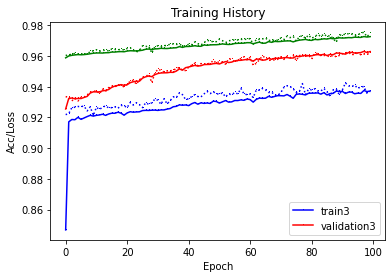

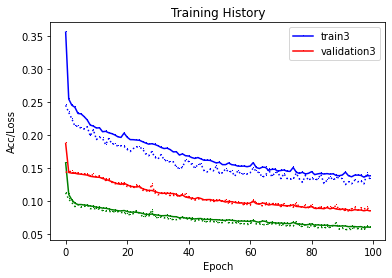

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.64536357e-02 8.40425491e-06 1.96695328e-06 ... 1.76950991e-02
  3.89152169e-02 5.66244125e-07]
 [2.18766630e-02 1.19537115e-04 4.32133675e-06 ... 2.17006147e-01
  6.71148300e-05 5.66244125e-07]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [4.32133675e-06 2.00569630e-05 2.04741955e-05 ... 5.02904058e-02
  9.38445330e-04 1.32322311e-05]
 [7.67573714e-03 1.63248628e-01 2.81972289e-02 ... 1.63160563e-02
  6.97925389e-02 4.57677245e-02]]
……………………………………………………………………………………………
开始进行模型评估
<class 'numpy.ndarray'>
<class 'list'>
0.5429746698419571
|||||||||||||||||||||||||||||||
缺陷率
accuracy
recall-avg
recall-0-defect
recall-1-nodefect
precision-avg
precision-0-defect
precision-1-nodefect
F1-score
F1-score-0-defect
F1-score-1-nodefect
|||||||||||||||||||||||||||||||
0.5429746698419571
0.9333189001948474
0.9271612696311642
0.855518711511132

F:\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:84: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
F:\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Top1的sub-accuracy
0.9639261744966443
##############################
Top1的sub-precision
Task2的Precision的分子 2194.0
Task2的Precision的分母 2686
0.8168279970215935
##############################
Top1的sub-recall
Task2的Recall的分子 2153.0
Task2的Recall的分母 2485
0.8663983903420523
##############################
data length:  4619
top 1:
sum =  3673
rate =  0.795193764884174
##############################
top 3:
sum =  4210
rate =  0.9114526953886123
##############################
top 5:
sum =  4520
rate =  0.9785667893483438
##############################
top 10:
sum =  4570
rate =  0.9893916432128166
##############################
top10范围下的平均排名MRR：
1.4277899343544858
##############################
各类别缺陷分布统计:
[44, 28, 35, 2107, 1430, 84, 78, 28]
##############################
各类别缺陷预测正确率统计:
[14, 0, 7, 2010, 1218, 25, 31, 6]
|||||||||||||||||||||||||||||||
0.9639261744966443
0.8168279970215935
0.8663983903420523
0.795193764884174
0.9114526953886123
0.9785667893483438
0.9893916432128166
0.009525871400736

F:\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:270: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
F:\Programming\Anaconda\lib\site-packages\ipykernel_launcher.py:275: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Top1的sub-accuracy
0.9736631305477239
##############################
Top1的sub-precision
Task3的Precision的分子 1540.3333333333335
Task3的Precision的分母 2173
0.7088510507746587
##############################
Top1的sub-recall
Task3的Recall的分子 1438.0
Task3的Recall的分母 2508
0.5733652312599681
##############################
data length:  4619
top 1:
sum =  3013
rate =  0.6523056938731328
##############################
top 3:
sum =  3728
rate =  0.8071011041350942
##############################
top 5:
sum =  4095
rate =  0.8865555315003247
##############################
top 10:
sum =  4314
rate =  0.9339683914267157
##############################
top10范围下的平均排名MRR：
1.8291608715808994
##############################
各类别缺陷分布统计:
[0, 68, 347, 429, 477, 648, 476, 418, 366, 160, 72, 58, 59, 31, 23, 14, 0, 0, 0, 0]
##############################
各类别缺陷预测正确率统计:
[0, 54, 253, 234, 266, 355, 296, 261, 195, 70, 24, 26, 19, 0, 0, 5, 0, 0, 0, 0]
|||||||||||||||||||||||||||||||
0.9736631305477239
0.7088510507746587
0.573

In [10]:
   
show_train_history(train_history,'output1_acc','output2_acc','output3_acc','val_output1_acc','val_output2_acc','val_output3_acc')
show_train_history(train_history,'output1_loss','output2_loss','output3_loss','val_output1_loss','val_output2_loss','val_output3_loss')    

#模型预测
predProb = model.predict(test_Features1,batch_size = 30)

#模型评分
#     score = average_precision_score(test_Label1,predProb[0])
#     print("******* score *********")
#     print(score)
#     print("***********************")
# 保存整个模型
#     model.save('kfold/model_' + software + str(k) +'.h5')
#     print("Model saved!")
print(predProb[1])
#模型评估
#任务1评估
eval1(predProb[0],test_Label1)
#任务2评估
eval2(predProb[1],test_df2)
#任务3评估
eval3(predProb[2],test_df3)

In [11]:
attention_vector1 = np.mean(get_activations(model,
                                           test_Features1,
                                           print_shape_only=True,
                                           layer_name='attention_vec1')[0], axis=1).squeeze()
print(attention_vector1.shape)
# attention_vector2 = np.mean(get_activations(model,
#                                            test_Features1[0:50],
#                                            print_shape_only=True,
#                                            layer_name='attention_vec2')[0], axis=1).squeeze()
# print(attention_vector2.shape)
# attention_vector3 = np.mean(get_activations(model,
#                                            test_Features1[0:50],
#                                            print_shape_only=True,
#                                            layer_name='attention_vec3')[0], axis=1).squeeze()
# print(attention_vector3.shape)

----- activations -----
(4619, 1, 96)
(4619, 96)


In [12]:
print(train_history.history['output2_loss'])
print(train_history.history['output3_loss'])

[0.187469090001398, 0.1435903078128067, 0.14253662639317086, 0.14243164258985042, 0.14136675931737336, 0.1410741446673926, 0.14029848040022444, 0.13959782777500235, 0.13779147691973928, 0.13709134438944964, 0.13650513505387654, 0.1362772628876052, 0.13446784866783337, 0.13319309937568427, 0.13156485109904004, 0.12970652836884597, 0.12783534731852822, 0.12639111105203787, 0.12559819443032622, 0.127330895564573, 0.12497448274019678, 0.12281670503106233, 0.12215896944868744, 0.12157283628566785, 0.12242115888066045, 0.11895941429066177, 0.11757995609801895, 0.11627168627636296, 0.11631993865080255, 0.11504414552364951, 0.11313920247750726, 0.11224546578997646, 0.11209286947301662, 0.11223324652914056, 0.1118250920697519, 0.11168181103558746, 0.11046511812211994, 0.10766147049005761, 0.10949458352415921, 0.10643614927755071, 0.1054718040510341, 0.10483515485832434, 0.10368737286064024, 0.10552762398506475, 0.10421034797267387, 0.10225416697909229, 0.10252651204726569, 0.10262782713810295, 

In [13]:
print(train_history.history['output2_acc'])
print(train_history.history['output3_acc'])

[0.9255211805892662, 0.9323967656444997, 0.9326573577169969, 0.9321562208451324, 0.9323867432067184, 0.9323199245758622, 0.9330415607661658, 0.9337331277394094, 0.9359180810106449, 0.9366898296527105, 0.9366397173044979, 0.9366163306180191, 0.9373613535425934, 0.9375918748686853, 0.9382132828020562, 0.9396298277765198, 0.9404149419019109, 0.940892691744787, 0.9413704409743318, 0.940939464265453, 0.9413002814565387, 0.94263998443042, 0.9432613932001516, 0.9436155293979668, 0.9436121880092134, 0.9456000274218261, 0.9464653213919763, 0.9470098909330642, 0.9465555265101777, 0.9478751839712695, 0.948630229755788, 0.9489643192699085, 0.9490511818682783, 0.9491079772329579, 0.949405318639598, 0.9493552049771041, 0.9502071360367338, 0.9516203393436571, 0.9507750895640501, 0.9524188163477072, 0.9528464517315552, 0.9533843376747064, 0.9539021778103504, 0.9534812230454016, 0.9537050641189997, 0.9544166777201807, 0.9545068811656606, 0.9545503131737608, 0.9550080170976148, 0.9552184945995693, 0.954

[2.6760065e-07 4.4304891e-03 5.2483682e-07 2.6656135e-03 2.9256074e-07
 3.4249281e-03 1.5997453e-02 2.1991711e-07 3.0993249e-07 3.2975851e-07
 3.2941131e-07 3.1830490e-07 8.5117761e-05 2.9295938e-07 1.3719314e-04
 1.0389703e-06 3.0818001e-07 3.0191285e-07 1.9133297e-07 5.9230113e-04
 5.4042782e-03 3.7092815e-07 2.0379784e-04 1.0477768e-03 4.5271283e-03
 2.5604115e-07 2.8482009e-07 7.6751235e-07 1.0317505e-02 3.2530119e-07
 2.7801170e-07 1.4672695e-02 2.8802825e-07 4.5877758e-02 3.9453948e-07
 7.2154313e-07 2.6746152e-03 3.1893283e-02 4.0411570e-07 2.7097582e-07
 8.9926030e-03 1.1700257e-02 1.6137339e-02 5.6894687e-06 3.3024038e-04
 1.7347154e-05 2.5746917e-07 3.1615585e-07 1.6424718e-03 6.8950567e-07
 5.8893594e-03 2.4698667e-07 1.2153827e-06 4.9838422e-07 4.1594248e-07
 3.1048802e-07 5.2456835e-06 7.7639767e-03 8.9577370e-05 3.3480984e-07
 2.9592286e-07 4.0363528e-07 1.8194217e-02 9.8627759e-03 2.7041884e-07
 3.5933257e-07 5.1769808e-07 3.4245500e-07 5.7304036e-02 2.6810179e-07
 4.280

<AxesSubplot:title={'center':'Attention'}>

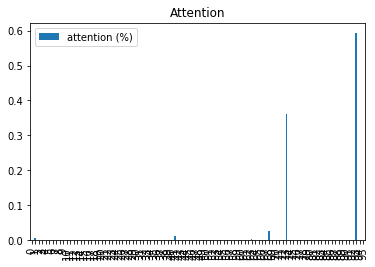

In [14]:
attention_vector_final1 = np.mean(np.array(attention_vector1), axis=0)
print(attention_vector_final1)
pd.DataFrame(attention_vector1[50], columns=['attention (%)']).plot(kind='bar',
                                                                    title='Attention')